<a href="https://colab.research.google.com/github/yesiltepe-hidir/GAN/blob/main/IAF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import MultivariateNormal, SigmoidTransform, Uniform, TransformedDistribution
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

## MAF Model

In [415]:
class MaskedLinear(nn.Linear):
    """ same as Linear except has a configurable mask on the weights """
    
    def __init__(self, in_features, out_features, bias=True):
        super().__init__(in_features, out_features, bias)        
        self.register_buffer('mask', torch.ones(out_features, in_features))
        
    def set_mask(self, mask):
        self.mask.data.copy_(torch.from_numpy(mask.astype(np.uint8).T))
        
    def forward(self, input):
        return F.linear(input, self.mask * self.weight, self.bias)


In [416]:
class MADE(nn.Module):
    def __init__(self, nin, hidden_sizes, nout, num_masks=1, natural_ordering=False):
        """
        nin: integer; number of inputs
        hidden sizes: a list of integers; number of units in hidden layers
        nout: integer; number of outputs, which usually collectively parameterize some kind of 1D distribution
              note: if nout is e.g. 2x larger than nin (perhaps the mean and std), then the first nin
              will be all the means and the second nin will be stds. i.e. output dimensions depend on the
              same input dimensions in "chunks" and should be carefully decoded downstream appropriately.
              the output of running the tests for this file makes this a bit more clear with examples.
        num_masks: can be used to train ensemble over orderings/connections
        natural_ordering: force natural ordering of dimensions, don't use random permutations
        """
        
        super().__init__()
        self.nin = nin
        self.nout = nout
        self.hidden_sizes = hidden_sizes
        assert self.nout % self.nin == 0, "nout must be integer multiple of nin"
        
        # define a simple MLP neural net
        self.net = []
        hs = [nin] + hidden_sizes + [nout]
        for h0,h1 in zip(hs, hs[1:]):
            self.net.extend([
                    MaskedLinear(h0, h1),
                    nn.ReLU(),
                ])
        self.net.pop() # pop the last ReLU for the output layer
        self.net = nn.Sequential(*self.net)
        
        # seeds for orders/connectivities of the model ensemble
        self.natural_ordering = natural_ordering
        self.num_masks = num_masks
        self.seed = 0 # for cycling through num_masks orderings
        
        self.m = {}
        self.update_masks() # builds the initial self.m connectivity
        # note, we could also precompute the masks and cache them, but this
        # could get memory expensive for large number of masks.
        
    def update_masks(self):
        if self.m and self.num_masks == 1: return # only a single seed, skip for efficiency
        L = len(self.hidden_sizes)
        
        # fetch the next seed and construct a random stream
        rng = np.random.RandomState(self.seed)
        self.seed = (self.seed + 1) % self.num_masks
        
        # sample the order of the inputs and the connectivity of all neurons
        self.m[-1] = np.arange(self.nin) if self.natural_ordering else rng.permutation(self.nin)
        for l in range(L):
            self.m[l] = rng.randint(self.m[l-1].min(), self.nin-1, size=self.hidden_sizes[l])
        
        # construct the mask matrices
        masks = [self.m[l-1][:,None] <= self.m[l][None,:] for l in range(L)]
        masks.append(self.m[L-1][:,None] < self.m[-1][None,:])
        
        # handle the case where nout = nin * k, for integer k > 1
        if self.nout > self.nin:
            k = int(self.nout / self.nin)
            # replicate the mask across the other outputs
            masks[-1] = np.concatenate([masks[-1]]*k, axis=1)
        
        # set the masks in all MaskedLinear layers
        layers = [l for l in self.net.modules() if isinstance(l, MaskedLinear)]
        for l,m in zip(layers, masks):
            l.set_mask(m)
    
    def forward(self, x):
        return self.net(x)

In [417]:
class ARMLP(nn.Module):
    """ a 4-layer auto-regressive MLP, wrapper around MADE net """

    def __init__(self, nin, nout, nh):
        super().__init__()
        self.net = MADE(nin, [nh, nh, nh], nout, num_masks=1, natural_ordering=True)
        
    def forward(self, x):
        return self.net(x)

In [418]:
class IAF(nn.Module):
    """ Masked Autoregressive Flow that uses a MADE-style network for fast forward """
    
    def __init__(self, dim, parity, net_class=ARMLP, nh=24):
        super().__init__()
        self.dim = dim
        # self.net = net_class(nh, dim) # my autoregressive
        self.net = ARMLP(dim, 2*dim, nh)

        self.parity = parity

    def backward(self, x):
        # here we see that we are evaluating all of z in parallel, so density estimation will be fast
        st = self.net(x)
        s, t = st.split(self.dim, dim=1)
        z = x * torch.exp(s) + t
        # reverse order, so if we stack MAFs correct things happen
        z = z.flip(dims=(1,)) if self.parity else z
        log_det = torch.sum(s, dim=1)
        return z, log_det
    
    def forward(self, z):
        # we have to decode the x one at a time, sequentially
        x = torch.zeros_like(z)
        log_det = torch.zeros(z.size(0))
        z = z.flip(dims=(1,)) if self.parity else z
        for i in range(self.dim):
            st = self.net(x.clone()) # clone to avoid in-place op errors if using IAF
            s, t = st.split(self.dim, dim=1)
            x[:, i] = (z[:, i] - t[:, i]) * torch.exp(-s[:, i])
            log_det += -s[:, i]
        return x, log_det

In [419]:
class NormalizingFlow(nn.Module):
    """ A sequence of Normalizing Flows is a Normalizing Flow """

    def __init__(self, flows):
        super().__init__()
        self.flows = nn.ModuleList(flows)

    def forward(self, x):
        m, _ = x.shape
        log_det = torch.zeros(m)
        zs = [x]
        for flow in self.flows:
            x, ld = flow.forward(x)
            log_det += ld
            zs.append(x)
        return zs, log_det

    def backward(self, z):
        m, _ = z.shape
        log_det = torch.zeros(m)
        xs = [z]
        for flow in self.flows[::-1]:
            z, ld = flow.backward(z)
            log_det += ld
            xs.append(z)
        return xs, log_det

In [420]:
class NormalizingFlowModel(nn.Module):
    """ A Normalizing Flow Model is a (prior, flow) pair """
    
    def __init__(self, prior, flows):
        super().__init__()
        self.prior = prior
        self.flow = NormalizingFlow(flows)
    
    def forward(self, x):
        zs, log_det = self.flow.forward(x)
        prior_logprob = self.prior.log_prob(zs[-1]).view(x.size(0), -1).sum(1)
        return zs, prior_logprob, log_det

    def backward(self, z):
        xs, log_det = self.flow.backward(z)
        return xs, log_det
    
    def sample(self, num_samples):
        z = self.prior.sample((num_samples,))
        xs, _ = self.flow.backward(z)
        return xs

In [866]:
class MLP(nn.Module):
    """ a simple 4-layer MLP """

    def __init__(self, nin, nout, nh):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(nin, nh),
            nn.LeakyReLU(0.2),
            nn.Linear(nh, nh),
            nn.LeakyReLU(0.2),
            nn.Linear(nh, nh),
            nn.LeakyReLU(0.2),
            nn.Linear(nh, nout),
        )
    def forward(self, input):
        return self.net(input)

In [867]:
class VAE(nn.Module):
    def __init__(self, dim, prior, flows):
        super().__init__()
        self.dim = dim
        self.prior = prior
        self.encoder = NormalizingFlowModel(prior, flows)
        self.decoder = MLP(dim, 2*dim, 128)
    
    def forward(self, input):
        zs, prior_logprob, log_det = self.encoder(input.float())
        kl = prior_logprob + log_det

        m, s = self.decoder(zs[-1]).split(self.dim, dim=1)
        eps = torch.randn(s.size())
        x_hat = m + eps * torch.exp(s)
        recon = F.mse_loss(input, x_hat)

        loss = torch.sum(-kl + recon)
        return m, s, loss

## Training

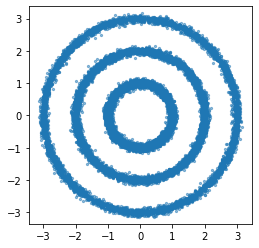

In [868]:
class DatasetMoons:
    """ two half-moons """
    def sample(self, n):
        moons = datasets.make_moons(n_samples=n, noise=0.05)[0].astype(np.float32)
        return torch.from_numpy(moons)

class PointDataset:
  def __init__(self, file_path):
    self.data = np.load(file_path)
  
  def __getitem__(self, idx):
    return self.data[idx]
  
  def __len__(self):
    return self.data.shape[0]

d = PointDataset('/content/DatasetB_train.npy')
x = torch.utils.data.DataLoader(d, batch_size=256, shuffle=True)
plt.figure(figsize=(4,4))
plt.scatter(d[:,0], d[:,1], s=5, alpha=0.5)
plt.axis('equal');

In [869]:
# Prior
dim = 2
prior = MultivariateNormal(torch.zeros(2), torch.eye(2))
flows = [IAF(dim=2, parity=0, nh=24) for i in range(4)]
# construct the model
model = VAE(dim, prior, flows)

In [870]:
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0) # todo tune WD
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  39412


In [871]:
num_epoch = 25
steps = 0
for epoch in range(num_epoch):
    for points in x:
        m, s, loss = model(points.float())
        
        model.zero_grad()
        loss.backward()
        optimizer.step()

        steps += 1

        if steps % 100 == 0:
            print(f"[{epoch}/{num_epoch}] {loss.item()}")
            print('--------------------')

[1/25] 934.4033203125
--------------------
[3/25] 931.61669921875
--------------------
[5/25] 940.03369140625
--------------------
[6/25] 935.285400390625
--------------------
[8/25] 935.1883544921875
--------------------
[10/25] 939.0286865234375
--------------------
[11/25] 951.3224487304688
--------------------
[13/25] 941.8681640625
--------------------
[15/25] 930.9166259765625
--------------------
[16/25] 934.4942626953125
--------------------
[18/25] 935.5183715820312
--------------------
[20/25] 927.1829223632812
--------------------
[22/25] 929.7796020507812
--------------------
[23/25] 927.39990234375
--------------------


torch.Size([256, 2])


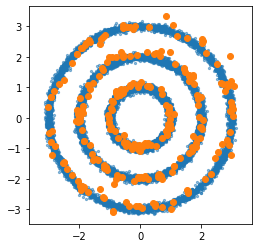

In [877]:
data_loader = torch.utils.data.DataLoader(d, batch_size=256, shuffle=True)
data = next(iter(data_loader))
print(data.size())
m, s, loss = model(data)
m.detach()
s.detach()
samples = m + torch.exp(s)*torch.randn(s.size())
plt.figure(figsize=(4,4))
plt.scatter(d[:,0], d[:,1], s=5, alpha=0.5)
plt.scatter(samples[:, 0].detach().numpy(), samples[:, 1].detach().numpy())
plt.axis('equal');

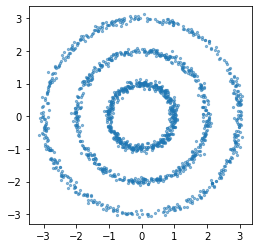

In [878]:
d = PointDataset('/content/DatasetB_test.npy')
x = torch.utils.data.DataLoader(d, batch_size=256, shuffle=True)
plt.figure(figsize=(4,4))
plt.scatter(d[:,0], d[:,1], s=5, alpha=0.5)
plt.axis('equal');

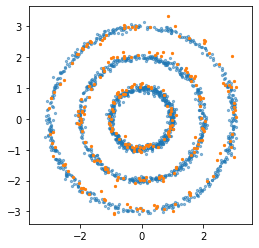

In [881]:
samples = m + torch.exp(s)*torch.randn(s.size())
plt.figure(figsize=(4,4))
plt.scatter(d[:,0], d[:,1], s=5, alpha=0.5)
plt.scatter(samples[:, 0].detach().numpy(), samples[:, 1].detach().numpy(), s=5)
plt.axis('equal');

Text(0.5, 1.0, 'z -> x')

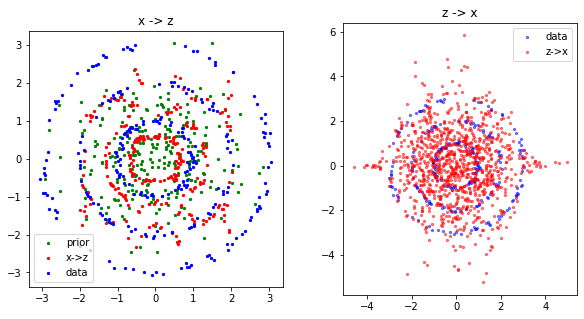

In [810]:
model.eval()

points = next(iter(x)).float()
zs, prior_logprob, log_det = model(points)
z = zs[-1]

x = points.detach().numpy()
z = z.detach().numpy()
p = model.prior.sample([128, 2]).squeeze()
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(p[:,0], p[:,1], c='g', s=5)
plt.scatter(z[:,0], z[:,1], c='r', s=5)
plt.scatter(points[:,0], x[:,1], c='b', s=5)
plt.legend(['prior', 'x->z', 'data'])
plt.axis('scaled')
plt.title('x -> z')

zs = model.sample(128*8)
z = zs[-1]
z = z.detach().numpy()
plt.subplot(122)
plt.scatter(points[:,0], points[:,1], c='b', s=5, alpha=0.5)
plt.scatter(z[:,0], z[:,1], c='r', s=5, alpha=0.5)
plt.legend(['data', 'z->x'])
plt.axis('scaled')
plt.title('z -> x')